# MNAD Evaluation

## Libraries import

In [1]:
import argparse
import os
import torch
import torch.utils.data as data
import torchvision.transforms as T
import torch.nn as nn
import matplotlib.pyplot as plt

from data.CustomDataset import CustomImageDataset
from data.CustomDataset import augment_dataset
from data.CustomDataset import show_augmented_dataset_info
from evaluation_utils import *

## Constants

In [2]:
DATASET_DIR_SUFFIX = 'images'

## Parameters

In [3]:
args_dict = {
  "gpus": "1",                            # gpus (set 1 or None)
  "batch_size": 1,                        # batch size for testing
  "h": 256,                               # height of input images
  "w": 256,                               # width of input images
  "c": 3,                                 # channel of input images
  "method": "recon",                      # The target task for anoamly detection  (pred or recon)
  "t_length": 1,                          # length of the frame sequences
  "fdim": 512,                            # channel dimension of the features
  "mdim": 512,                            # channel dimension of the memory items
  "msize": 10,                            # number of the memory items
  "alpha": 0.7,                           # weight for the anomality score
  "th": 0.015,                            # threshold for test updating
  "threshold": 0.36,                      # threshold for the anomaly score
  "num_workers": 1,                       # number of workers for the test loader
  "dataset_type": "ade_20k_and_taco",     # type of dataset: clean_road, ade_20k_and_taco
  "dataset_path": "./dataset",            # directory of data
  "label_path": "./dataset",              # directory of labels
  "label_file": "test_labels.csv",        # name of the label file
  "model_path": "model/trained",          # directory of model
  "model_file": "model.pth",              # name of the model file
  "m_items_path": "model/trained",        # directory of memory items
  "m_items_file": "keys.pt",              # name of the memory items file
  "create_predictions": True,             # create predictions for the test set
  "use_inference_dataset": False,         # use inference dataset for testing
  "dataset_inference": "personal",        # dataset for inference: personal, clean_road, ade_20k_and_taco
  "augment": False,                       # whether to use data augmentation
}

args = argparse.Namespace(**args_dict)

## GPU Configurations

In [4]:
print(torch.cuda.is_available())
if args.gpus is not None and torch.cuda.is_available():
  print(torch.cuda.is_available())

  print(torch.cuda.device_count())

  print(torch.cuda.current_device())

  print(torch.cuda.device(0))

  print(torch.cuda.get_device_name(0))

True
True
1
0
Quadro T2000 with Max-Q Design


In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
if args.gpus is None:
    gpus = "0"
    os.environ["CUDA_VISIBLE_DEVICES"]= gpus
else:
    gpus = ""
    for i in range(len(args.gpus)):
        gpus = gpus + args.gpus[i] + ","
    os.environ["CUDA_VISIBLE_DEVICES"]= gpus[:-1]

#torch.backends.cudnn.enabled = True # make sure to use cudnn for computational performance

## Data loading

In [6]:
if args.use_inference_dataset:
    dataset_for_data = args.dataset_inference
else:
    dataset_for_data = args.dataset_type

test_folder = os.path.join(args.dataset_path, dataset_for_data, DATASET_DIR_SUFFIX)
test_label_folder = os.path.join(args.label_path, dataset_for_data)
test_label_file = os.path.join(test_label_folder, args.label_file)

#transform = T.Resize((args.h,args.w))
transform = T.Compose([T.ToTensor(),])

# Loading dataset
test_dataset = CustomImageDataset(test_label_file, test_folder, transform = transform, use_cv2=True)
test_size = len(test_dataset)

test_batch = data.DataLoader(test_dataset, batch_size = args.batch_size,
                              shuffle=True, num_workers=args.num_workers, drop_last=False)
batch_size = len(test_batch)

### Data augmentation

In [ ]:
if args.augment:
    # Create augmentation transform list
    augmentation_transform_list = []


    enabled = True
    if enabled:
        augmentation_transform = T.Compose([
            T.ToPILImage(),
            T.RandAugment(),
            T.ToTensor(),    
        ])
        transform_name = "RandAugment"
        applications_number = 3
        transform_dict = {"name": transform_name, "transform": augmentation_transform, "applications_number": applications_number}
        augmentation_transform_list.append(transform_dict)


    # Apply augment_dataset function to create augmented dataset
    augmented_test_dataset = augment_dataset(test_dataset, augmentation_transform_list, create_dict=False)
    augmented_test_size = len(augmented_test_dataset)

    augmented_test_batch = data.DataLoader(augmented_test_dataset, batch_size = args.batch_size,
                                shuffle=True, num_workers=args.num_workers, drop_last=False)
    augmented_batch_size = len(augmented_test_batch)

    test_batch = augmented_test_batch

    show_augmented_dataset_info(augmented_test_dataset)

## Model loading

In [7]:
# Loading the trained model
model_file = os.path.join(args.model_path, args.dataset_type, args.model_file)
m_items_file = os.path.join(args.m_items_path, args.dataset_type, args.m_items_file)
#model = torch.load(args.model_dir, map_location=torch.device('cpu'))
model = torch.load(model_file)
model.cuda()
#m_items = torch.load(args.m_items_dir, map_location=torch.device('cpu'))
m_items = torch.load(m_items_file)

## Evaluation

In [8]:
loss_func_mse = nn.MSELoss(reduction='none')

psnr_list = {}
feature_distance_list = {}

# Populate the dictionaries with the image names and empty lists
for img_name in test_dataset.imgs_labels["filename"].to_numpy():
    psnr_list[img_name] = []
    feature_distance_list[img_name] = []

m_items_test = m_items.clone()

In [9]:
print('Evaluation of', dataset_for_data)
model.eval()

for j,(images, labels) in enumerate(test_batch):
    imgs = images["file"]
    img_name = images["name"][0]

    if args.gpus is not None and torch.cuda.is_available():
        imgs = imgs.cuda()

    if args.method == 'pred':
        outputs, feas, updated_feas, m_items_test, softmax_score_query, softmax_score_memory, _, _, _, compactness_loss = model.forward(imgs[:,0:3*4], m_items_test, False)
        mse_imgs = torch.mean(loss_func_mse((outputs[0]+1)/2, (imgs[0,3*4:]+1)/2)).item()
        mse_feas = compactness_loss.item()

        # Calculating the threshold for updating at the test time
        point_sc = point_score(outputs, imgs[:,3*4:])

    else:
        outputs, feas, updated_feas, m_items_test, softmax_score_query, softmax_score_memory, compactness_loss = model.forward(imgs, m_items_test, False)
        mse_imgs = torch.mean(loss_func_mse((outputs[0]+1)/2, (imgs[0]+1)/2)).item()
        mse_feas = compactness_loss.item()

        # Calculating the threshold for updating at the test time
        point_sc = point_score(outputs, imgs)

    if  point_sc < args.th:
        query = nn.functional.normalize(feas, dim=1)
        query = query.permute(0,2,3,1) # b X h X w X d
        m_items_test = model.memory.update(query, m_items_test, False)
    
    psnr_list[img_name].append(psnr(mse_imgs))
    feature_distance_list[img_name].append(mse_feas)

# Measuring the abnormality score and the AUC
anomaly_score_total_list = []

# Calculating the abnormality score as the sum of the PSNR (inverted) and the feature distance
psnr_listed = anomaly_score_list_inv(list(psnr_list.values()))
feature_distance_listed = anomaly_score_list(list(feature_distance_list.values()))
anomaly_score_total_list = score_sum(psnr_listed, feature_distance_listed, args.alpha)

anomaly_score_total_list = np.asarray(anomaly_score_total_list)
anomaly_score_total_list = np.mean(anomaly_score_total_list, axis=1)
anomaly_score_total_list = np.expand_dims(anomaly_score_total_list, axis=0).T

print(anomaly_score_total_list.shape)
print(anomaly_score_total_list)

# Calculating the AUC
anomaly_score_total_list = np.expand_dims(anomaly_score_total_list, axis=0)
labels_list = np.expand_dims(test_dataset.imgs_labels["label"].to_numpy(), axis=0)

accuracy = AUC(anomaly_score_total_list, labels_list)

print('The result of ', dataset_for_data)
print('AUC: ', accuracy*100, '%')

Evaluation of ade_20k_and_taco
(1250, 1)
[[0.36192291]
 [0.37947003]
 [0.30859063]
 ...
 [0.55274287]
 [0.58905266]
 [0.58200977]]
The result of  ade_20k_and_taco
AUC:  81.75546666666666 %


### Plots

#### ROC Curve

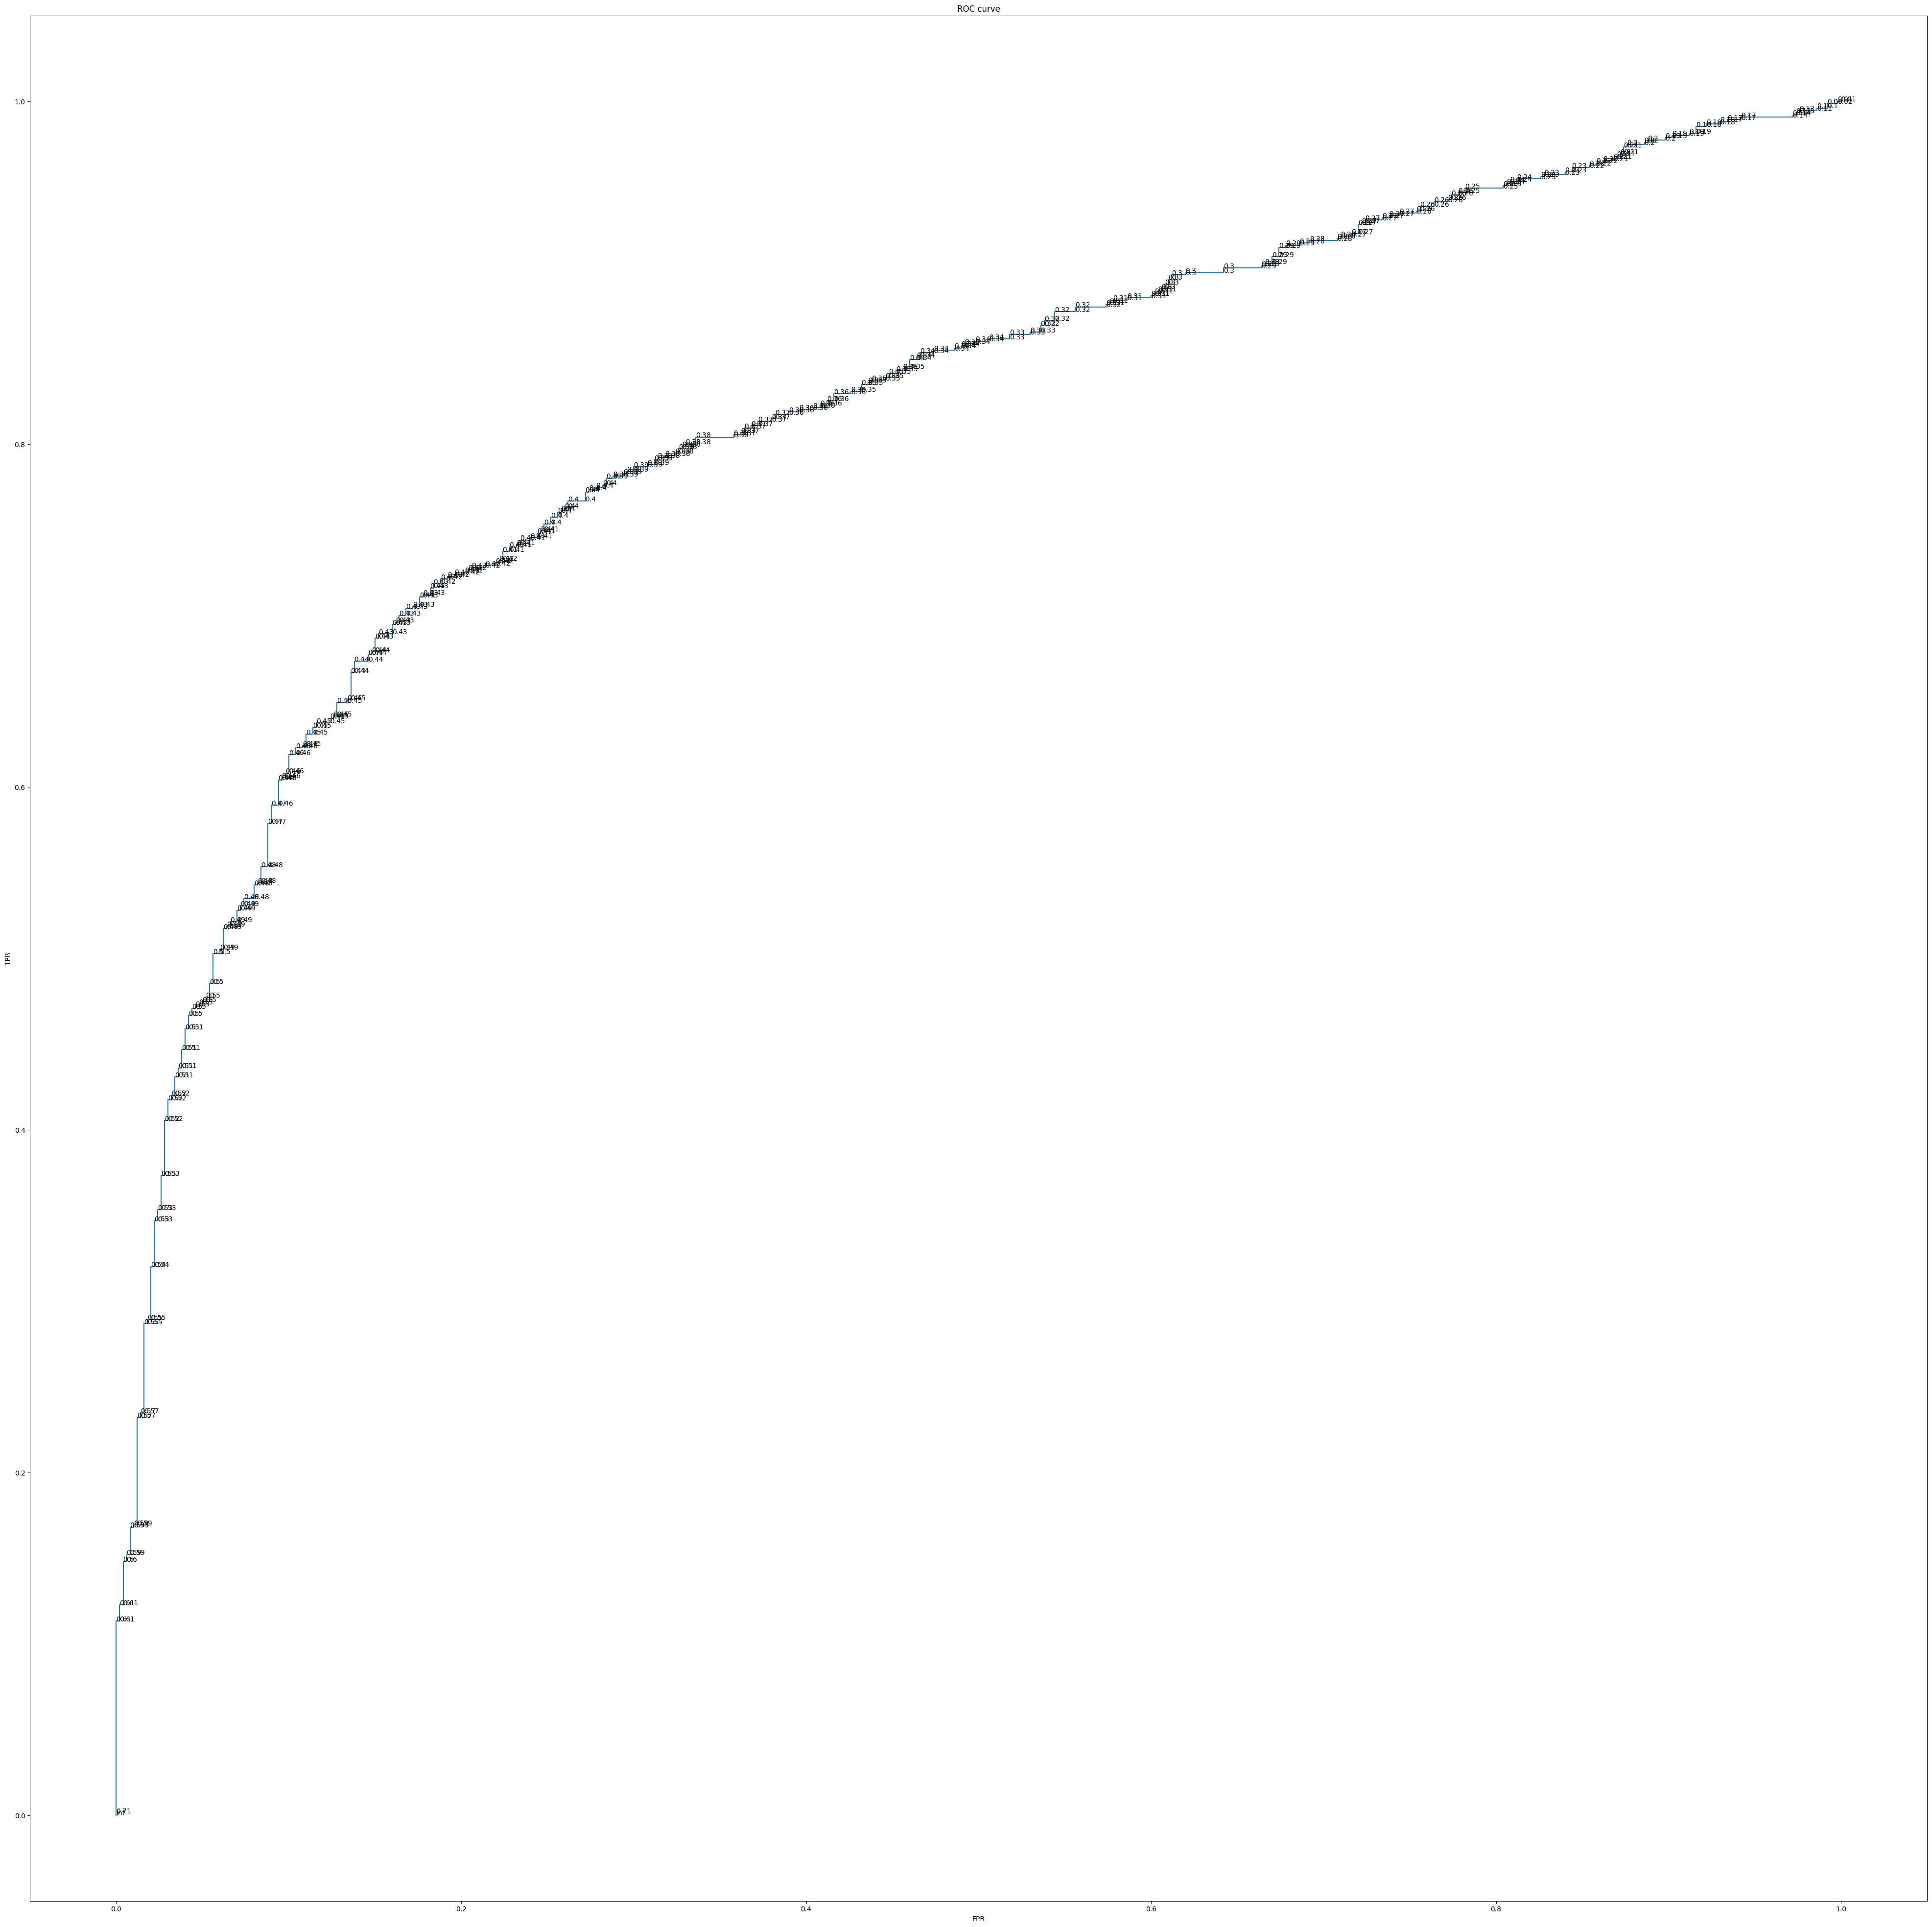

In [10]:
# Get the ROC curve
fpr, tpr, threshold = get_roc_curve(anomaly_score_total_list, labels_list)

# Plot the ROC curve
plt.figure(figsize=(50,50))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
# Add threshold value to the plot
for i in range(len(threshold)):
    plt.text(fpr[i], tpr[i], round(threshold[i],2))
#plt.grid()

plt.show()

#### Confusion matrix

In [11]:
if len(threshold) < 30:
    # Get the confusion matrices
    cm_list, cm_disp_list = get_confusion_matrix_list(anomaly_score_total_list, labels_list, threshold)

    # Plot for_each_row confusion matrices for each row
    for_each_row = 3
    if len(cm_list) <= for_each_row:
        for_each_row = len(cm_list)
        figsize = (15,5)
    else:
        figsize = (15,15)
    figure, axis = plt.subplots(len(cm_list)//for_each_row, for_each_row, figsize=figsize, constrained_layout=True)
    for i in range(len(cm_list)):
        if len(axis.shape) == 1:
            cm_disp_list[i].plot(ax=axis[i])
            axis[i].set_title('Confusion matrix: Threshold = %f' % threshold[i])
        else:
            cm_disp_list[i].plot(ax=axis[i//for_each_row, i%for_each_row])
            axis[i//for_each_row, i%for_each_row].set_title('Confusion matrix: Threshold = %f' % threshold[i])
        
    plt.show()

## Classification

Classification of  ade_20k_and_taco
Threshold:  0.36
Accuracy:  73.11999999999999 %
Precision:  75.36764705882352 %
Recall:  82.0 %
F1:  78.544061302682 %


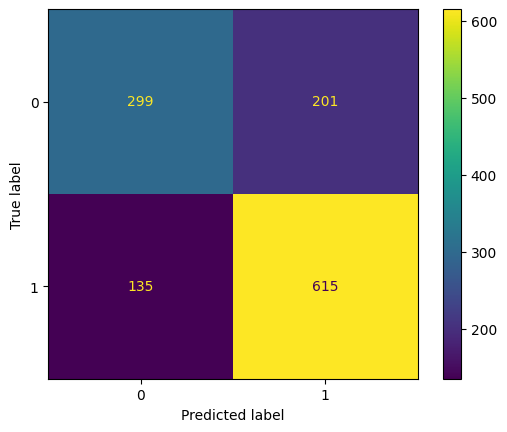

In [12]:
# Classify with threshold
thresholded_score_list, accuracy, precision, recall, f1, cm = classify_with_threshold(anomaly_score_total_list, labels_list, args.threshold)
print('Classification of ', dataset_for_data)
print('Threshold: ', args.threshold)
print('Accuracy: ', accuracy*100, '%')
print('Precision: ', precision*100, '%')
print('Recall: ', recall*100, '%')
print('F1: ', f1*100, '%')

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Save the results if required
if args.create_predictions:
    # Get label DataFrame
    label_df = test_dataset.imgs_labels
    # Add the anomaly score and the classification
    label_df['classification'] = thresholded_score_list.astype(int)
    label_df['anomaly_score'] = anomaly_score_total_list[0]
    # Write the result to csv file
    label_df.to_csv(os.path.join(test_label_folder, 'test_labels_and_scores.csv'))